## Explainabel AI

This notebook is based on New York Cab dataset (taken from Kaggle) and tryes to explain RandomForest model.
Global and local explanation will be used and also different methods and libraries.

Data is taken from <a href="https://www.kaggle.com/shivamsarawagi/yellowcabfareprediction/data">here</a>

Based on this data set we can try to predict the cab price depending on different data.
Can be used on the mobile application like if customer marks 2 points on the map, he can get aproximatly the price.

And finaly we will try to explain our model why and how it works.

### Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.ensemble
import sklearn.metrics
import sklearn.model_selection
import eli5.sklearn

from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence

Read the data. We read not the whole dataset, since the computational time will be really big.
We take 80000 samples from train set and 20000 samples from test set.

Additionally string (pickup time and dropoff time) will be converted to pandas.Timestamp object. This will help us later generate a new important features.

In [2]:
df = pd.read_csv('train_2015.csv', nrows=80000)
#convert pickup_datetime to real datetime
df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

df_test = pd.read_csv('test_2015.csv', nrows=20000)
df_test.tpep_pickup_datetime = pd.to_datetime(df_test.tpep_pickup_datetime)
df_test.tpep_dropoff_datetime = pd.to_datetime(df_test.tpep_dropoff_datetime)

In [3]:
df.isnull().sum()

RateCodeID               0
VendorID                 0
dropoff_latitude         0
dropoff_longitude        0
extra                    0
fare_amount              0
improvement_surcharge    0
mta_tax                  0
passenger_count          0
payment_type             0
pickup_latitude          0
pickup_longitude         0
store_and_fwd_flag       0
tip_amount               0
tolls_amount             0
total_amount             0
tpep_dropoff_datetime    0
tpep_pickup_datetime     0
trip_distance            0
dtype: int64

In [5]:
df_test.isnull().sum()

RateCodeID                   0
RatecodeID               20000
VendorID                     0
dropoff_latitude             0
dropoff_longitude            0
extra                        0
fare_amount                  0
improvement_surcharge        0
mta_tax                      0
passenger_count              0
payment_type                 0
pickup_latitude              0
pickup_longitude             0
store_and_fwd_flag           0
tip_amount                   0
tolls_amount                 0
total_amount                 0
tpep_dropoff_datetime        0
tpep_pickup_datetime         0
trip_distance                0
dtype: int64

## Clean the data
in some frames there is a negative fare was found, so seems to be this data was not correctly written.
Such frames will be just deleted.

Also we concentrate us only on New York and take care about data with max 7 passangers.

In [6]:
# cleaning functions
#remove negative fare
def remove_negative_fare_amount(df):
    return df[(df['fare_amount'] > 0)]


#removing rows outside newyork city
def remove_rows_latitude_longitude_not_in_range(df):
    MAX_LONGITUDE = -71.586532
    MIN_LONGITUDE = -75.663242

    MAX_LATITUDE = 45.959555
    MIN_LATITUDE = 35.168973,

    df = df[(MIN_LONGITUDE <= df.dropoff_longitude) &(df.dropoff_longitude <= MAX_LONGITUDE)
            & (MIN_LONGITUDE <= df.pickup_longitude) &(df.pickup_longitude <= MAX_LONGITUDE)
            & (MIN_LATITUDE <= df.dropoff_latitude) & (df.dropoff_latitude <= MAX_LATITUDE)
            & (MIN_LATITUDE <= df.pickup_latitude) & (df.pickup_latitude <= MAX_LATITUDE)]
    
    return df

# Removing rows with passenger count not in range
def remove_rows_passenger_count_not_in_range(df):
    return df[(df.passenger_count > 0) & (df.passenger_count < 7)]

In [7]:
#clean data
def clean_data(df):
    old_size = len(df)
    df = remove_negative_fare_amount(df)
    new_size = len(df)
    print('Cleaned data for fare amount. New size: %d Total Rows removed: %d' % (new_size, old_size - new_size))
    
    old_size = new_size
    df = remove_rows_latitude_longitude_not_in_range(df)
    new_size = len(df)
    print('Cleaned data for latitude longitude. New size: %d Total Rows removed: %d' % (new_size, old_size - new_size))
    
    old_size = new_size
    df = remove_rows_passenger_count_not_in_range(df)
    new_size = len(df)
    print('Cleaned data for passenger count. New size: %d Total Rows removed: %d' % (new_size, old_size - new_size))
    return df

print("Train data:")
df = clean_data(df)
print("Test data:")
df_test = clean_data(df_test)

Train data:
Cleaned data for fare amount. New size: 79962 Total Rows removed: 38
Cleaned data for latitude longitude. New size: 78324 Total Rows removed: 1638
Cleaned data for passenger count. New size: 78284 Total Rows removed: 40
Test data:
Cleaned data for fare amount. New size: 19985 Total Rows removed: 15
Cleaned data for latitude longitude. New size: 19581 Total Rows removed: 404
Cleaned data for passenger count. New size: 19574 Total Rows removed: 7


## Visualazing
Just plots latitude against longitude and we see almost map of the New York.
In the middle seems to be a central park

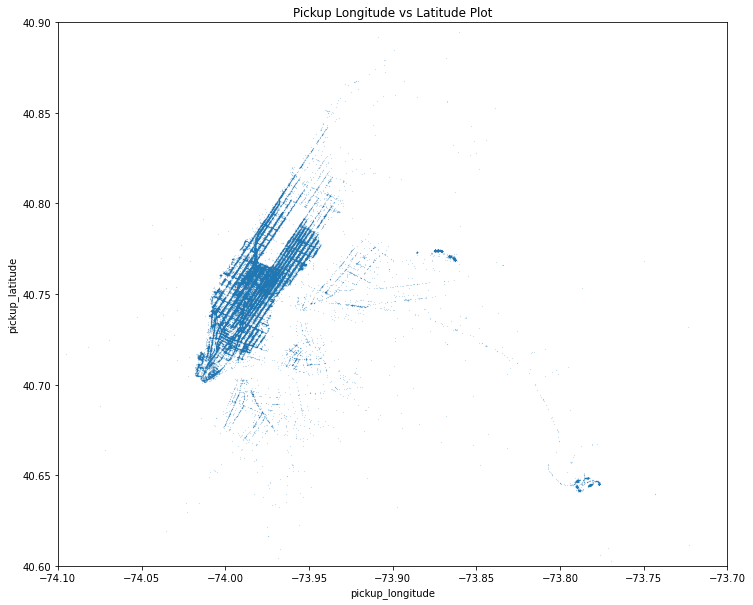

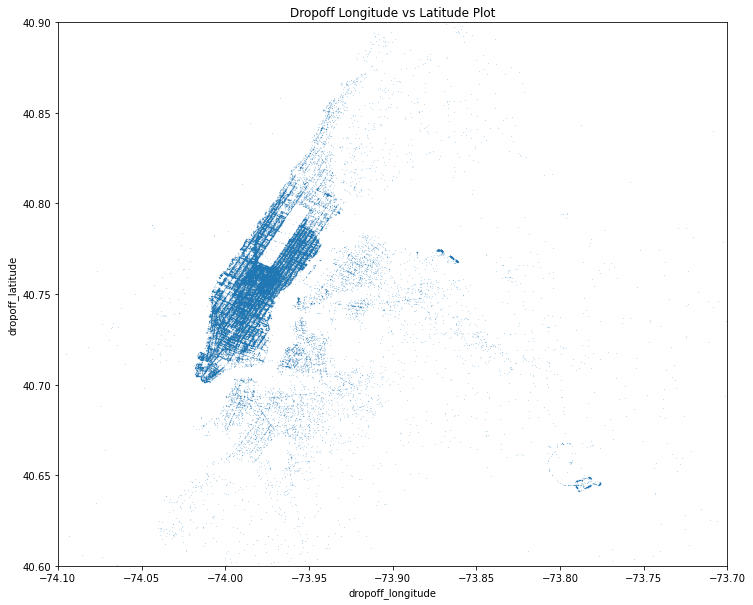

In [8]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
plt.xlabel('pickup_longitude')
plt.ylabel('pickup_latitude')
plt.title('Pickup Longitude vs Latitude Plot')
ax.scatter(df['pickup_longitude'], df['pickup_latitude'], s = 0.007, alpha = 1)
plt.show()

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
plt.xlabel('dropoff_longitude')
plt.ylabel('dropoff_latitude')
plt.title('Dropoff Longitude vs Latitude Plot')
ax.scatter(df['dropoff_longitude'], df['dropoff_latitude'], s = 0.007, alpha = 1)
plt.show()

## Add new features
We can add some really useful features like
<ul>
    <li>trip time
    <li>weekday (monday, tuesday, etc.) [1-7]
    <li>category for the hours (evening, day, nigth, etc.) [1-5]
        <ul>
            <li>1 - night
            <li>2 - morning
            <li>3 - lunch time
            <li>4 - after lunch time + evening
            <li>5 - late evening
        </ul>
    <li>airport trip or not
</ul>

In [12]:
#add some useful features
#calculate haversine distance
def haversine_distance(lon1,lat1,lon2,lat2):
    p = 0.01745329251
    a = 0.5-np.cos((lat2-lat1)*p)/2+np.cos(lat1*p)*np.cos(lat2*p)*(1-np.cos((lon2-lon1)*p))/2
    return 12742 * np.arcsin(np.sqrt(a))

def add_eucledian_distance_feature(df):
    df['eucledian_distance'] = haversine_distance(df.dropoff_longitude, df.dropoff_latitude, 
                                                  df.pickup_longitude, df.pickup_latitude)
    return df

def add_time_feature(df):
    df['year'] = df.tpep_pickup_datetime.apply(lambda x: x.year)
    df['month'] = df.tpep_pickup_datetime.apply(lambda x: x.month)
    df['weekday'] = df.tpep_pickup_datetime.apply(lambda x: x.isoweekday())
    df['hour'] = df.tpep_pickup_datetime.apply(lambda x: x.hour)
    df['day_cat'] = df.tpep_pickup_datetime.apply(lambda x: calc_day_category(x))
    
    return df

def calc_timediff(df):
    t = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    return int(t.total_seconds() / 60) + 1

def add_timediff_feature(df):
    df['timediff'] = df.apply(calc_timediff, axis=1)
    return df

# Checks if the given lat lon is in airport region.
# Currently, only considering JFK for the airport.
def is_near_airport(lon, lat):
    MAX_RADIUS = 2
    
    # JFK coordinates
    AIRPORT_COORDINATES = [(40.645112, -73.785524)]

    within_radius = False
    for t in AIRPORT_COORDINATES:
        within_radius = within_radius or (haversine_distance(lon, lat, t[1], t[0]) <= MAX_RADIUS)
        
    return within_radius

# Checks if the trip is an airport trip or not.
def is_airport_trip(x):
    return (is_near_airport(x.dropoff_longitude, x.dropoff_latitude) 
            or is_near_airport(x.pickup_longitude, x.pickup_latitude))

def add_trip_feature(df):
    df['is_airport_trip'] = df.apply(is_airport_trip, axis=1)
    return df

#use one hot encoding!!!!!!!
def calc_day_category(x):
    if (x.hour >= 0 and x.hour <= 4):
        return 1 #night
    elif (x.hour > 4 and x.hour <= 10):
        return 2 #morning
    elif (x.hour > 10 and x.hour <= 14):
        return 3 #mittag   
    elif (x.hour > 14 and x.hour <= 18):
        return 4 #after dax and evening
    elif (x.hour > 18 and x.hour <= 21):
        return 5 #late evening
    elif (x.hour > 21 and x.hour <= 23):
        return 1 #night

## one hot encoding for day_cat and weekday
def one_hot_encoding(data, base_feature):
    return pd.get_dummies(data, columns = [base_feature])

In [13]:
## add features
df = add_eucledian_distance_feature(df)
df = add_time_feature(df)
df = add_trip_feature(df)
df = add_timediff_feature(df)
df = one_hot_encoding(df, "day_cat")
df = one_hot_encoding(df, "weekday")

In [14]:
df_test = add_eucledian_distance_feature(df_test)
df_test = add_time_feature(df_test)
df_test = add_trip_feature(df_test)
df_test = add_timediff_feature(df_test)
df_test = one_hot_encoding(df_test, "day_cat")
df_test = one_hot_encoding(df_test, "weekday")

In [15]:
base_features = ["dropoff_latitude", "dropoff_longitude", "pickup_latitude", "pickup_longitude", "passenger_count",
                "weekday_1", "weekday_2", "weekday_3", "weekday_4", "weekday_5", "weekday_6", "weekday_7", 
                 "day_cat_1", "day_cat_2", "day_cat_3", "day_cat_4", "day_cat_5", "is_airport_trip", "trip_distance", "timediff"]
y_train = df.fare_amount
X_train = df[base_features]

y_test = df_test.fare_amount
X_test = df_test[base_features]

## Train the model

In [18]:
#Train model
rf = sklearn.ensemble.RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [19]:
#Weights on train set
perm_train = eli5.sklearn.PermutationImportance(rf, random_state=42).fit(X_train, y_train)
eli5.show_weights(perm_train, feature_names=base_features)

Weight,Feature
1.0501 ± 0.0149,trip_distance
0.2851 ± 0.0191,timediff
0.0656 ± 0.0048,dropoff_longitude
0.0333 ± 0.0007,pickup_longitude
0.0174 ± 0.0005,dropoff_latitude
0.0115 ± 0.0012,pickup_latitude
0.0079 ± 0.0017,weekday_3
0.0045 ± 0.0013,passenger_count
0.0037 ± 0.0025,weekday_1
0.0036 ± 0.0006,day_cat_1


## Explanation
Explanation starts normally from here, since in the real world we get already pretrained model, which we have to explain. May be we will have the test set.

So the whole explanation will be based on this test set.

### Permutation Importance
First we would like to find out which features are most important. Additional bonus with this method we will see whether our model is overfitted or not.

we just check preformance of our model based on R2-Score and it looks quite good.

In [23]:
print(sklearn.metrics.r2_score(y_test, rf.predict(X_test)))

0.9302658861900613


In [20]:
#Weigth in test set
perm_test = eli5.sklearn.PermutationImportance(rf, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm_test, feature_names=base_features)

Weight,Feature
1.0289 ± 0.0143,trip_distance
0.2373 ± 0.0132,timediff
0.0307 ± 0.0024,dropoff_longitude
0.0036 ± 0.0061,pickup_longitude
0.0035 ± 0.0003,is_airport_trip
0.0017 ± 0.0017,dropoff_latitude
0.0012 ± 0.0027,passenger_count
0.0005 ± 0.0007,day_cat_5
0.0003 ± 0.0007,day_cat_4
0.0003 ± 0.0007,weekday_1


We see that some features have some small negative values. it can point that our model a little bit overfitted. 
In our case not so much overfitted, otherwise we can already stop here

The features "Trip distance" and "Trip time" are really important for our model. This is normally like this, if you drive far away or your trip takes much time, it will be expensive. Not we can look how this 2 features globally contributes to the result.

Feature "dropoff_longitude" is also can be seen as important, so we will take it also in our explanation.

It's kind of interesting that day time or day week have almost no impact on the price. I would await that on weekend in the evening the price will be more that some other day.

And it means that we could train our model only using these 2 most important features and our model will be able to predict the prices quite good.

## Global explanation

### ICE Plots

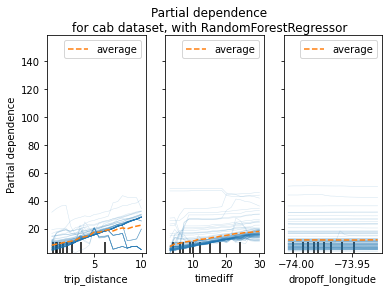

In [21]:
features = ['trip_distance', 'timediff', 'dropoff_longitude']
display = PartialDependenceDisplay.from_estimator(
    rf,
    X_test,
    features,
    kind="both",
    subsample=100,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)

display.figure_.suptitle(
    "Partial dependence\n"
    "for cab dataset, with RandomForestRegressor"
)
display.figure_.subplots_adjust(hspace=0.3)

On these plots we clearly see linear dependes with increasing trend for features trip distance and trip time. It means if you travel far away and trip takes long time you have to pay more. We can say that our hypothesis is confirmed.

### Partial dependece plot

/opt/anaconda3/envs/python38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


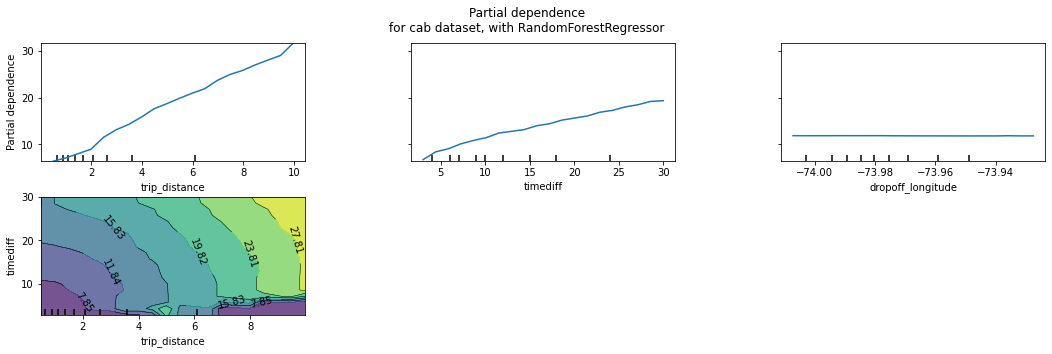

In [22]:
features = ['trip_distance', 'timediff', 'dropoff_longitude', ('trip_distance', 'timediff')]

plot_partial_dependence(rf, X_test, features,
                        n_jobs=3, grid_resolution=20)

fig = plt.gcf()
fig.suptitle("Partial dependence\n"
    "for cab dataset, with RandomForestRegressor")
fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.set_size_inches(18, 5)

On the partial dependence plot we see basically the same what we already saw on ICE plots. 
But the iteraction plot of 2 features "trip distance" and "trip time" is quite interesting. 

Here we can see that of you travel not so far away but the trip takes a lot of time you will pay more. The most expensive case for instance if you travel about 10 km and your trip takes more then 10 minutes you will pay more then 27$.

But even if you travel far away but trip time unter 5 minutes you will pay less then 10$. And again we confirmed our hypothesis that price depends not only on trip distance but also it depends from the trip time.

